# Fashion MNIST Dataset in PyTorch

A warmup exercise in CNNs and PyTorch because I'm an idiot and never backed up my projects until my laptop died. Anyway

## 1. Get Data

In [126]:
import os
import glob
import re
import gzip
import requests
import numpy as np
import torchvision

# get data
TEST =  { 'X' : 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz',
          'y' : 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz'  }

TRAIN = { 'X' : 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz',
          'y' : 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz' }

PROJ_ROOT = os.getcwd()
DATA_DIR = os.path.join(PROJ_ROOT,'data/mnist/')

def download_extract(data: dict, dest: str, train: bool=True) -> None:
    # create data dir if it doesn't exist
    if not os.path.isdir(DATA_DIR):
        os.makedirs(DATA_DIR)
    if not os.listdir(DATA_DIR):
        res_x = requests.get(data['X'])
        res_y = requests.get(data['y'])   
        if train:
            with open(os.path.join(dest, 'X_train'), 'wb') as X:
                X.write(res_x.content)
            with open(os.path.join(dest, 'y_train'), 'wb') as y:
                y.write(res_y.content)
        else:
            with open(os.path.join(dest, 'X_test'), 'wb') as X:
                X.write(res_x.content)
            with open(os.path.join(dest, 'y_test'), 'wb') as y:
                y.write(res_y.content)
    else:
        print(f'Directory {DATA_DIR} is not empty, aborting')

def read_data(data_dir: str, train: bool=True)-> np.array:
    '''
    NOTE: Fashion MNIST Data from zalando research's github comes with flattened features
    we must resize these features into something PyTorch can process
    '''
    if train:
        for i in glob.glob(os.path.join(data_dir,'*_train')):
            if not re.match(r'X_*',os.path.basename(i)):
                with gzip.open(i, 'rb') as lbpath:
                    labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
            else:
                with gzip.open(i, 'rb') as imgpath:
                    images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16)
    else:
        for i in glob.glob(os.path.join(data_dir,'*_test')):
            if not re.match(r'X_*',os.path.basename(i)):
                with gzip.open(i, 'rb') as lbpath:
                    labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
            else:
                with gzip.open(i, 'rb') as imgpath:
                    images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16)
    images = images.reshape(len(labels), 784)
    return images,labels



In [ ]:
download_extract(TRAIN, DATA_DIR)
download_extract(TEST, DATA_DIR, train=False)

In [ ]:
X_train, y_train = read_data(DATA_DIR)

In [ ]:
# verify dataset dimensions
print(X_train.shape)
print(y_train.shape)

In [129]:
X_train_tensor = torchvision.transforms.ToTensor()
img_tensor = X_train_tensor(X_train)

In [135]:
img_tensor = img_tensor.view(-1,1,28,28) # reshaping the tensor with torch.view()
print(img_tensor.shape)
print(img_tensor[0])

torch.Size([60000, 1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 

In [ ]:
%matplotlib inline
# plot random sample
import matplotlib.pyplot as plt

plt.imshow(X_train[69].reshape((28,28))) # 784 features, a 28 by 28 image

## 2. Prepare Data for Processing

We skipped the bigger transformations since the MNIST-Fashion dataset already comes processed(images featurized, flattened) so all we need to do is to store the data into objects which PyTorch can process.

We store featurized image data into PyTorch `Dataset` objects(converting them into tensor inside the class) and run them through the `DataLoader` class

In [143]:
# Transform into PyTorch Dataset/Dataloader objects
import torch
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ImageDatasetV2(Dataset):
    toTensor = torchvision.transforms.ToTensor()
    def __init__(self, data: np.array, labels: np.array) -> None:
        self.data = self.toTensor(data).view(-1,1,28,28)
        self.labels = torch.from_numpy(labels)
    def __len__(self) -> int:
        return len(self.labels)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class ImageDataset(Dataset):
    '''
    NOTE: Fashion MNIST Data from zalando research's github comes with flattened features
    we must resize these features into something PyTorch can process
    torch.flatten() will help with that
    '''
    class_names = { 0: 	'T-shirt/top',
        1: 	'Trouser',
        2: 	'Pullover',
        3: 	'Dress',
        4: 	'Coat',
        5: 	'Sandal',
        6: 	'Shirt',
        7: 	'Sneaker',
        8: 	'Bag',
        9: 	'Ankle boot' }
    def __init__(self,data: np.array, classes: np.array) -> None:
        self.data = torch.unflatten(torch.from_numpy(data).to(dtype=torch.float32),1,(28,28),).unsqueeze(dim=1).to(device) # undsqueeze to add the colour channel dimension [NCWH]
        self.classes = torch.from_numpy(classes).to(dtype=torch.float32,device=device)
    def __get_class(self,idx):
        return self.classes[idx]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx],self.classes[idx]

In [144]:
# train_data = ImageDataset(X_train,y_train)
train_data = ImageDatasetV2(X_train, y_train)

In [145]:
# check the custom Dataset object
len(train_data), train_data.data.shape

(60000, torch.Size([60000, 1, 28, 28]))

In [ ]:
# as per documentation, the labels correspond to the following label names
class_names = { 0: 	'T-shirt/top',
1: 	'Trouser',
2: 	'Pullover',
3: 	'Dress',
4: 	'Coat',
5: 	'Sandal',
6: 	'Shirt',
7: 	'Sneaker',
8: 	'Bag',
9: 	'Ankle boot' }

In [147]:
# Let's verify the custom dataset object works

# let's pick a random sample from an arbitrary index
rand_img, rand_img_label = train_data.data[42].to('cpu'), train_data.labels[42].to('cpu')

In [148]:
# print out input data shape
rand_img.shape

torch.Size([1, 28, 28])

In [149]:
train_data.data.shape

torch.Size([60000, 1, 28, 28])

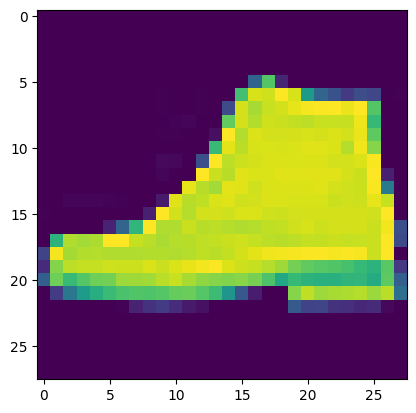

In [150]:
plt.imshow(rand_img[0])

In [151]:
# verify the label is correct 
print(f'label: {rand_img_label}, {class_names[rand_img_label.item()]}') # label should be an ankle boot

label: 9, Ankle boot


In [152]:
# Run them through the DataLoader class, with 100 samples per batch being processed
train_data_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=False)

## 3. Create Model

We're just going with a custom CNN model with Torch's built in `nn.Module`

In [153]:
from torch import nn

# Create custom CNN class

class MNISTCnn(nn.Module):
    '''
    MNISTCnn model, patterned on the TinyVGG architecture
    '''
    def __init__(self,input_shape: int, hidden_units: int, output_shape: int) -> None:
        '''
        input_shape - number of input features, ie, colour channel, width, height
        hidden_units - number of neurons in the hidden layers
        output_shape - number of classes/labels

        2 blocks of 2 conv layers and maxpooling layer
        a flatten and a classifier at the output
        '''
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)          
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)          
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units, # output dimension of block2 should be the input shape. HINT: check the output shape of block2 in the forward function
                          out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        print(x.shape)
        x = self.block2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        return x

In [154]:
# find out the shape of the output of block2 by creating an initial model object
torch.manual_seed(42)

test_model = MNISTCnn(input_shape=1, hidden_units=10, output_shape=10)
test_model

MNISTCnn(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [155]:
# create a test image

test_input = torch.randn([32,1,28,28])
test_image = test_input[1]
print(f'test image shape: {test_image.shape}')

test image shape: torch.Size([1, 28, 28])


In [ ]:
# test_model(test_input) will error because Linear input doesn't match output of 2nd conv block, hint: size is hidden_units*7*7

In [156]:
# Now we modify our model slightly so the input in the classification block matches the output of the final conv block
class MNISTCnnV2(nn.Module):
    '''
    MNISTCnn model, patterned on the TinyVGG architecture
    '''
    def __init__(self,input_shape: int, hidden_units: int, output_shape: int) -> None:
        '''
        input_shape - number of input features, ie, colour channel, width, height
        hidden_units - number of neurons in the hidden layers
        output_shape - number of classes/labels

        2 blocks of 2 conv layers and maxpooling layer
        a flatten and a classifier at the output
        '''
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)          
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)          
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, # output dimension of block2 should be the input shape; eg if output of block 2 is [10 7 7] , in_features should be 10*7*7
                          out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [157]:
torch.manual_seed(42)

test_model_2 = MNISTCnnV2(input_shape=1, hidden_units=10, output_shape=10)
# create a test image
test_input_2 = torch.randn([32,1,28,28])
test_image_2 = test_input[1]
print(f'test input shape: {test_input_2.shape}, test image shape: {test_image_2.shape}')

test input shape: torch.Size([32, 1, 28, 28]), test image shape: torch.Size([1, 28, 28])


In [158]:
# test the model
test_model_2(test_input_2).argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])

We can also find the dimensions of the `MaxPool2d()` function if we run the following formula:

$$

Input: (N,C,H_in,W_in)(N,C,H_in​,W_in​) or (C,H_in,W_in)(C,H_in​,W_in​)
\\
Output: (N,C,H_out,W_out)(N,C,H_out​,W_out​) or (C,H_out,W_out)(C,H_out​,W_out​), where
$$
$$
H_{out}​=\frac{H_{in}​+2∗padding[0]−dilation[0]×(kernelsize[0]−1)−1​}{stride[0]}+1\\
W_{out}=\frac{W_{in}+2∗padding[1]−dilation[1]×(kernelsize[1]−1)−1}{stride[1]}+1



$$

## 4. Train and Test Data

In [159]:
# now create a model we'll be working with
mnist_tinyvgg = MNISTCnnV2(input_shape=1, hidden_units=10,output_shape=len(class_names)) # grayscale == 1 colour channel as input shape
# mnist_tinyvgg.to(device=device)

In [160]:
# Choose cost function and optimizer
# using cross-entropy for multi-class classification
ce_loss = nn.CrossEntropyLoss()
# and using stochastic gradient descent as an optimizer
sgd_optim = torch.optim.SGD(params=mnist_tinyvgg.parameters(), lr=0.1)

In [161]:

# prepare data again, start from scratch
X_train, y_train = read_data(DATA_DIR)
X_test, y_test = read_data(DATA_DIR)
batches = 100
train_dl = DataLoader(ImageDatasetV2(X_train,y_train), batch_size=batches, shuffle=False)
test_dl = DataLoader(ImageDatasetV2(X_test,y_test), batch_size=batches, shuffle=False)


In [164]:
import torchmetrics

tmetrics_acc = torchmetrics.Accuracy(task='multiclass', num_classes = len(class_names)).to(device)

# bespoke accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = correct / len(y_pred)
    return acc

# Create a train and test functions
def train(train, model, loss_fn, optim):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X,y) in enumerate(train):
        # cast labels to long tensor
        X = X.to(device)
        y = y.type(torch.LongTensor).to(device)
        # 1. forward pass
        y_pred = model(X)
        # 2. calculate loss, compare predictions with actual values
        y_loss = loss_fn(y_pred, y)
        train_loss += y_loss
        # tmp_acc = tmetrics_acc(y_pred.argmax(dim=1), y)
        tmp_acc = accuracy_fn(y, y_pred.argmax(dim=1)) # y_pred is the prediction probabilities, the label being the index that has the highest probability
        train_acc += tmp_acc
        if batch > 0 and batch % 100 == 0:
            print(f'batch {batch} of {len(train)}: loss {y_loss}, accuracy: {tmp_acc*100}%')
        # 3. zero-grad to clear gradients
        optim.zero_grad() 
        # 4. backward pass
        y_loss.backward()
        # 5. optimizer step
        optim.step()
    return model, train_loss/len(train), train_acc/len(train)

def test(test, model, loss_fn):
    loss = 0
    acc = 0
    model.eval() # turn on eval mode
    with torch.inference_mode():
        for X,y in test:
            X = X.to(device)
            y = y.type(torch.LongTensor).to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
            # acc += tmetrics_acc(y_pred.argmax(dim=1),y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
    # calculate mean loss and accuracy
    mean_loss = loss/len(test)
    mean_acc = acc/len(test)
    return mean_loss,mean_acc

In [166]:
from tqdm.auto import tqdm
# test-loop on 3 epochs
epochs = 3

mnist_tinyvgg.to(device=device)
# train-test loop
for epoch in tqdm(range(epochs)):
    print(f'epoch: {epoch}')
    model, train_loss, train_acc = train(train=train_dl, model=mnist_tinyvgg, loss_fn=ce_loss, optim=sgd_optim)
    print(f'train loss: {train_loss}, train accuracy: {train_acc*100}%')
    loss, acc = test(test=test_dl, model=mnist_tinyvgg, loss_fn=ce_loss)
    print(f'test loss: {loss}, test accuracy: {acc*100}%')
    

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
batch 100 of 600: loss 0.21740899980068207, accuracy: 94.0%
batch 200 of 600: loss 0.3461986184120178, accuracy: 88.0%
batch 300 of 600: loss 0.23892204463481903, accuracy: 92.0%
batch 400 of 600: loss 0.3760848939418793, accuracy: 89.0%
batch 500 of 600: loss 0.36140143871307373, accuracy: 90.0%
train loss: 0.25402602553367615, train accuracy: 90.88166666666666%


 33%|███▎      | 1/3 [00:06<00:12,  6.38s/it]

test loss: 0.24404844641685486, test accuracy: 91.32000000000001%
epoch: 1
batch 100 of 600: loss 0.20357856154441833, accuracy: 94.0%
batch 200 of 600: loss 0.3456666171550751, accuracy: 87.0%
batch 300 of 600: loss 0.24491502344608307, accuracy: 91.0%
batch 400 of 600: loss 0.3729304373264313, accuracy: 88.0%
batch 500 of 600: loss 0.36994117498397827, accuracy: 89.0%
train loss: 0.2501995265483856, train accuracy: 90.95500000000001%


 67%|██████▋   | 2/3 [00:12<00:06,  6.37s/it]

test loss: 0.2373882383108139, test accuracy: 91.57166666666664%
epoch: 2
batch 100 of 600: loss 0.21826620399951935, accuracy: 94.0%
batch 200 of 600: loss 0.33751243352890015, accuracy: 87.0%
batch 300 of 600: loss 0.24662235379219055, accuracy: 93.0%
batch 400 of 600: loss 0.3837118446826935, accuracy: 88.0%
batch 500 of 600: loss 0.36604487895965576, accuracy: 89.0%
train loss: 0.2466646432876587, train accuracy: 91.06999999999994%


100%|██████████| 3/3 [00:18<00:00,  6.27s/it]

test loss: 0.23565082252025604, test accuracy: 91.59833333333347%
